In [1]:
import numpy as np
import pandas as pd
import tensorflow.compat.v1 as tf
import os
import sys
import matplotlib.pyplot as plt
from collections import deque
import random
import seaborn as sns
sns.set()
tf.disable_v2_behavior()

Instructions for updating:
non-resource variables are not supported in the long term


In [2]:
df = pd.read_csv('dataset/GOOG.csv')
df.head()

,Date,Open,High,Low,Close,Adj Close,Volume
0,2010-08-12,242.212219,247.622620,241.496490,246.251251,246.251251,4404700
1,2010-08-13,244.744751,245.840836,243.248245,243.418411,243.418411,3865500
2,2010-08-16,242.082077,245.180176,240.490494,243.038040,243.038040,2607300
3,2010-08-17,244.509506,247.597595,243.258255,245.505508,245.505508,3777600
4,2010-08-18,245.465469,245.680679,241.016022,241.316315,241.316315,5367400


In [3]:
from collections import deque
import random

class Model:
    def __init__(self, input_size, output_size, layer_size, learning_rate, name):
        with tf.variable_scope(name):
            self.X = tf.placeholder(tf.float32, (None, None, input_size))
            self.Y = tf.placeholder(tf.float32, (None, output_size))
            cell = tf.nn.rnn_cell.LSTMCell(layer_size, state_is_tuple = False)
            self.hidden_layer = tf.placeholder(tf.float32, (None, 2 * layer_size))
            self.rnn,self.last_state = tf.nn.dynamic_rnn(inputs=self.X,cell=cell,
                                                    dtype=tf.float32,
                                                    initial_state=self.hidden_layer)
            tensor_action, tensor_validation = tf.split(self.rnn[:,-1],2,1)
            feed_action = tf.layers.dense(tensor_action, output_size)
            feed_validation = tf.layers.dense(tensor_validation, 1)
            self.logits = feed_validation + tf.subtract(feed_action,tf.reduce_mean(feed_action,axis=1,keep_dims=True))
            self.cost = tf.reduce_sum(tf.square(self.Y - self.logits))
            self.optimizer = tf.train.AdamOptimizer(learning_rate = learning_rate).minimize(self.cost)
        
class Agent:

    LEARNING_RATE = 0.003
    BATCH_SIZE = 32
    LAYER_SIZE = 256
    OUTPUT_SIZE = 3
    EPSILON = 0.5
    DECAY_RATE = 0.005
    MIN_EPSILON = 0.1
    GAMMA = 0.99
    MEMORIES = deque()
    COPY = 1000
    T_COPY = 0
    MEMORY_SIZE = 300
    
    def __init__(self, state_size, window_size, trend, skip):
        self.state_size = state_size
        self.window_size = window_size
        self.half_window = window_size // 2
        self.trend = trend
        self.skip = skip
        tf.reset_default_graph()
        self.INITIAL_FEATURES = np.zeros((4, self.state_size))
        self.model = Model(self.state_size, self.OUTPUT_SIZE, self.LAYER_SIZE, self.LEARNING_RATE,
                           'real_model')
        self.model_negative = Model(self.state_size, self.OUTPUT_SIZE, self.LAYER_SIZE, self.LEARNING_RATE,
                                   'negative_model')
        self.sess = tf.InteractiveSession()
        self.sess.run(tf.global_variables_initializer())
        self.trainable = tf.trainable_variables()
    
    def _assign(self, from_name, to_name):
        from_w = tf.get_collection(tf.GraphKeys.TRAINABLE_VARIABLES, scope=from_name)
        to_w = tf.get_collection(tf.GraphKeys.TRAINABLE_VARIABLES, scope=to_name)
        for i in range(len(from_w)):
            assign_op = to_w[i].assign(from_w[i])
            self.sess.run(assign_op)

    def _memorize(self, state, action, reward, new_state, dead, rnn_state):
        self.MEMORIES.append((state, action, reward, new_state, dead, rnn_state))
        if len(self.MEMORIES) > self.MEMORY_SIZE:
            self.MEMORIES.popleft()

    def _select_action(self, state):
        if np.random.rand() < self.EPSILON:
            action = np.random.randint(self.OUTPUT_SIZE)
        else:
            action = self.get_predicted_action([state])
        return action

    def _construct_memories(self, replay):
        states = np.array([a[0] for a in replay])
        new_states = np.array([a[3] for a in replay])
        init_values = np.array([a[-1] for a in replay])
        Q = self.sess.run(self.model.logits, feed_dict={self.model.X:states, 
                                                   self.model.hidden_layer:init_values})
        Q_new = self.sess.run(self.model.logits, feed_dict={self.model.X:new_states, 
                                                       self.model.hidden_layer:init_values})
        Q_new_negative = self.sess.run(self.model_negative.logits, 
                                  feed_dict={self.model_negative.X:new_states, 
                                             self.model_negative.hidden_layer:init_values})
        replay_size = len(replay)
        X = np.empty((replay_size, 4, self.state_size))
        Y = np.empty((replay_size, self.OUTPUT_SIZE))
        INIT_VAL = np.empty((replay_size, 2 * self.LAYER_SIZE))
        for i in range(replay_size):
            state_r, action_r, reward_r, new_state_r, dead_r, rnn_memory = replay[i]
            target = Q[i]
            target[action_r] = reward_r
            if not dead_r:
                target[action_r] += self.GAMMA * Q_new_negative[i, np.argmax(Q_new[i])]
            X[i] = state_r
            Y[i] = target
            INIT_VAL[i] = rnn_memory
        return X, Y, INIT_VAL
    
    def get_state(self, t):
        window_size = self.window_size + 1
        d = t - window_size + 1
        block = self.trend[d : t + 1] if d >= 0 else -d * [self.trend[0]] + self.trend[0 : t + 1]
        res = []
        for i in range(window_size - 1):
            res.append(block[i + 1] - block[i])
        return np.array(res)
    
    def buy(self, initial_money,date1,close):
        starting_money = initial_money
        states_sell = []
        states_buy = []
        inventory = []
        state = self.get_state(0)
        date1 = date1
        init_value = np.zeros((1, 2 * self.LAYER_SIZE))
        for k in range(self.INITIAL_FEATURES.shape[0]):
            self.INITIAL_FEATURES[k,:] = state
        for t in range(0, len(close) - 1, self.skip):
            action, last_state = self.sess.run([self.model.logits,self.model.last_state],
                                                feed_dict={self.model.X:[self.INITIAL_FEATURES],
                                                            self.model.hidden_layer:init_value})
            action, init_value = np.argmax(action[0]), last_state
            next_state = self.get_state(t + 1)
            
            if action == 1 and initial_money >= close[t]:
                inventory.append(close[t])
                initial_money -= close[t]
                states_buy.append(t)
                print('day %d: buy 1 unit at price %f, total balance %f'% (t, close[t], initial_money))
                df1 = pd.DataFrame({'Date': date1[t+1], 'Close': [close[t+1]],'RESULT': ['Buy'] })
                if not os.path.isfile('13.double-duel-recurrent-q-learning-agent.csv'):
                    df1.to_csv('13.double-duel-recurrent-q-learning-agent.csv', index=False)
                else:
                    df1.to_csv('13.double-duel-recurrent-q-learning-agent.csv', index=False, mode='a', header=False)
            
            elif action == 2 and len(inventory):
                bought_price = inventory.pop(0)
                initial_money += close[t]
                states_sell.append(t)
                try:
                    invest = ((close[t] - bought_price) / bought_price) * 100
                except:
                    invest = 0
                print(
                    'day %d, sell 1 unit at price %f, investment %f %%, total balance %f,'
                    % (t, close[t], invest, initial_money)
                )
                df2 = pd.DataFrame({'Date': date1[t+1], 'Close': [close[t+1]],'RESULT': ['Sell'] })
                if not os.path.isfile('13.double-duel-recurrent-q-learning-agent.csv'):
                    df2.to_csv('13.double-duel-recurrent-q-learning-agent.csv', index=False)
                else:
                    df2.to_csv('13.double-duel-recurrent-q-learning-agent.csv', index=False, mode='a', header=False)
            else:
                print(
                    'day %d, hold UNIT at price %f,  total balance %f,'
                    % (t+1, close[t+1], initial_money)
                )
                df3 = pd.DataFrame({'Date': date1[t+1], 'Close': [close[t+1]], 'RESULT': ['Hold']})
                if not os.path.isfile('13.double-duel-recurrent-q-learning-agent.csv'):
                    df3.to_csv('13.double-duel-recurrent-q-learning-agent.csv', index=False)
                else:
                    df3.to_csv('13.double-duel-recurrent-q-learning-agent.csv', index=False, mode='a', header=False)
            
            new_state = np.append([self.get_state(t + 1)], self.INITIAL_FEATURES[:3, :], axis = 0)
            self.INITIAL_FEATURES = new_state
        invest = ((initial_money - starting_money) / starting_money) * 100
        print(
                '\ntotal gained %f, total investment %f %%'
                % (initial_money - starting_money, invest)
            )
        total_gains = initial_money - starting_money
            
    
    def train(self, iterations, checkpoint, initial_money):
        for i in range(iterations):
            total_profit = 0
            inventory = []
            state = self.get_state(0)
            starting_money = initial_money
            init_value = np.zeros((1, 2 * self.LAYER_SIZE))
            for k in range(self.INITIAL_FEATURES.shape[0]):
                self.INITIAL_FEATURES[k,:] = state
            for t in range(0, len(self.trend) - 1, self.skip):
                if (self.T_COPY + 1) % self.COPY == 0:
                    self._assign('real_model', 'negative_model')
                
                if np.random.rand() < self.EPSILON:
                    action = np.random.randint(self.OUTPUT_SIZE)
                else:
                    action, last_state = self.sess.run([self.model.logits,
                                                  self.model.last_state],
                                                  feed_dict={self.model.X:[self.INITIAL_FEATURES],
                                                             self.model.hidden_layer:init_value})
                    action, init_value = np.argmax(action[0]), last_state
                    
                next_state = self.get_state(t + 1)
                
                if action == 1 and starting_money >= self.trend[t]:
                    inventory.append(self.trend[t])
                    starting_money -= self.trend[t]
                
                elif action == 2 and len(inventory) > 0:
                    bought_price = inventory.pop(0)
                    total_profit += self.trend[t] - bought_price
                    starting_money += self.trend[t]
                    
                invest = ((starting_money - initial_money) / initial_money)
                new_state = np.append([self.get_state(t + 1)], self.INITIAL_FEATURES[:3, :], axis = 0)
                
                self._memorize(self.INITIAL_FEATURES, action, invest, new_state, 
                               starting_money < initial_money, init_value[0])
                self.INITIAL_FEATURES = new_state
                batch_size = min(len(self.MEMORIES), self.BATCH_SIZE)
                replay = random.sample(self.MEMORIES, batch_size)
                X, Y, INIT_VAL = self._construct_memories(replay)
                
                cost, _ = self.sess.run([self.model.cost, self.model.optimizer], 
                                        feed_dict={self.model.X: X, self.model.Y:Y,
                                                  self.model.hidden_layer: INIT_VAL})
                self.T_COPY += 1
                self.EPSILON = self.MIN_EPSILON + (1.0 - self.MIN_EPSILON) * np.exp(-self.DECAY_RATE * i)
            if (i+1) % checkpoint == 0:
                print('epoch: %d, total rewards: %f.3, cost: %f, total money: %f'%(i + 1, total_profit, cost,
                                                                                  starting_money))

In [4]:
close = df.Close.values.tolist()
initial_money = 10000
window_size = 30
skip = 1
batch_size = 32
agent = Agent(state_size = window_size, 
              window_size = window_size, 
              trend = close, 
              skip = skip)
agent.train(iterations = 1, checkpoint = 1, initial_money = initial_money)

Instructions for updating:
This class is equivalent as tf.keras.layers.LSTMCell, and will be replaced by that in Tensorflow 2.0.
Instructions for updating:
Please use `keras.layers.RNN(cell)`, which is equivalent to this API
Instructions for updating:
Please use `layer.add_weight` method instead.
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
Instructions for updating:
Use keras.layers.Dense instead.
Instructions for updating:
Please use `layer.__call__` method instead.
epoch: 1, total rewards: 4778.214983.3, cost: 0.121425, total money: 10941.604998


In [5]:
date = df.Date.values.tolist()
agent.buy(initial_money = initial_money,date1=date,close=close)

day 1, hold UNIT at price 243.418411,  total balance 10000.000000,
day 2, hold UNIT at price 243.038040,  total balance 10000.000000,
day 3, hold UNIT at price 245.505508,  total balance 10000.000000,
day 4, hold UNIT at price 241.316315,  total balance 10000.000000,
day 5, hold UNIT at price 234.219223,  total balance 10000.000000,
day 6, hold UNIT at price 231.241241,  total balance 10000.000000,
day 7, hold UNIT at price 232.267273,  total balance 10000.000000,
day 8, hold UNIT at price 225.920914,  total balance 10000.000000,
day 9, hold UNIT at price 227.537537,  total balance 10000.000000,
day 10, hold UNIT at price 225.715714,  total balance 10000.000000,
day 11, hold UNIT at price 229.644638,  total balance 10000.000000,
day 12, hold UNIT at price 226.571579,  total balance 10000.000000,
day 13, hold UNIT at price 225.235229,  total balance 10000.000000,
day 14, hold UNIT at price 230.395401,  total balance 10000.000000,
day 15, hold UNIT at price 231.821823,  total balance 100

day 122, hold UNIT at price 305.795807,  total balance 10000.000000,
day 123, hold UNIT at price 307.452454,  total balance 10000.000000,
day 124, hold UNIT at price 309.499512,  total balance 10000.000000,
day 125, hold UNIT at price 308.558563,  total balance 10000.000000,
day 126, hold UNIT at price 308.528534,  total balance 10000.000000,
day 127, hold UNIT at price 312.562561,  total balance 10000.000000,
day 128, hold UNIT at price 314.389404,  total balance 10000.000000,
day 129, hold UNIT at price 312.387390,  total balance 10000.000000,
day 130, hold UNIT at price 312.422424,  total balance 10000.000000,
day 131, hold UNIT at price 312.942932,  total balance 10000.000000,
day 132, hold UNIT at price 315.355347,  total balance 10000.000000,
day 133, hold UNIT at price 305.410400,  total balance 10000.000000,
day 134, hold UNIT at price 305.965973,  total balance 10000.000000,
day 135, hold UNIT at price 304.714722,  total balance 10000.000000,
day 136, hold UNIT at price 305.32

day 246, hold UNIT at price 300.885895,  total balance 9996.391388,
day 247, hold UNIT at price 289.049042,  total balance 9996.391388,
day 248, hold UNIT at price 289.809814,  total balance 9996.391388,
day 249, hold UNIT at price 273.283295,  total balance 9996.391388,
day 249: buy 1 unit at price 273.283295, total balance 9723.108093
day 250, sell 1 unit at price 286.992004, investment 5.016300 %, total balance 10010.100097,
day 252, hold UNIT at price 281.346344,  total balance 10010.100097,
day 253, hold UNIT at price 282.167175,  total balance 10010.100097,
day 254, hold UNIT at price 278.893890,  total balance 10010.100097,
day 255, hold UNIT at price 269.769775,  total balance 10010.100097,
day 256, hold UNIT at price 266.841827,  total balance 10010.100097,
day 257, hold UNIT at price 252.692688,  total balance 10010.100097,
day 258, hold UNIT at price 245.705704,  total balance 10010.100097,
day 259, hold UNIT at price 249.334335,  total balance 10010.100097,
day 260, hold UN

day 371, hold UNIT at price 290.705719,  total balance 10028.438445,
day 372, hold UNIT at price 292.847839,  total balance 10028.438445,
day 373, hold UNIT at price 298.463470,  total balance 10028.438445,
day 374, hold UNIT at price 304.849854,  total balance 10028.438445,
day 375, hold UNIT at price 303.688690,  total balance 10028.438445,
day 376, hold UNIT at price 305.230225,  total balance 10028.438445,
day 377, hold UNIT at price 306.036041,  total balance 10028.438445,
day 378, hold UNIT at price 303.258270,  total balance 10028.438445,
day 379, hold UNIT at price 306.406403,  total balance 10028.438445,
day 380, hold UNIT at price 305.185181,  total balance 10028.438445,
day 381, hold UNIT at price 303.083069,  total balance 10028.438445,
day 382, hold UNIT at price 303.563568,  total balance 10028.438445,
day 383, hold UNIT at price 302.622620,  total balance 10028.438445,
day 384, hold UNIT at price 307.307312,  total balance 10028.438445,
day 385, hold UNIT at price 304.27

day 501, hold UNIT at price 320.590576,  total balance 10028.438445,
day 502, hold UNIT at price 321.436432,  total balance 10028.438445,
day 503, hold UNIT at price 321.496490,  total balance 10028.438445,
day 504, hold UNIT at price 321.321320,  total balance 10028.438445,
day 505, hold UNIT at price 330.335327,  total balance 10028.438445,
day 506, hold UNIT at price 334.664673,  total balance 10028.438445,
day 507, hold UNIT at price 334.104095,  total balance 10028.438445,
day 508, hold UNIT at price 336.771759,  total balance 10028.438445,
day 509, hold UNIT at price 338.908905,  total balance 10028.438445,
day 510, hold UNIT at price 338.108093,  total balance 10028.438445,
day 511, hold UNIT at price 335.090088,  total balance 10028.438445,
day 512, hold UNIT at price 338.928925,  total balance 10028.438445,
day 513, hold UNIT at price 338.738739,  total balance 10028.438445,
day 514, hold UNIT at price 339.654663,  total balance 10028.438445,
day 515, hold UNIT at price 334.94

day 626, hold UNIT at price 387.362366,  total balance 10026.301299,
day 627, hold UNIT at price 393.078064,  total balance 10026.301299,
day 627: buy 1 unit at price 393.078064, total balance 9633.223235
day 628, sell 1 unit at price 391.601593, investment -0.375618 %, total balance 10024.824828,
day 630, hold UNIT at price 391.821808,  total balance 10024.824828,
day 631, hold UNIT at price 394.304291,  total balance 10024.824828,
day 632, hold UNIT at price 396.841827,  total balance 10024.824828,
day 633, hold UNIT at price 403.828827,  total balance 10024.824828,
day 634, hold UNIT at price 396.626617,  total balance 10024.824828,
day 635, hold UNIT at price 398.163177,  total balance 10024.824828,
day 636, hold UNIT at price 400.255249,  total balance 10024.824828,
day 637, hold UNIT at price 395.780792,  total balance 10024.824828,
day 638, hold UNIT at price 395.460449,  total balance 10024.824828,
day 639, hold UNIT at price 400.290283,  total balance 10024.824828,
day 640, ho

day 748, hold UNIT at price 453.738739,  total balance 10024.824828,
day 749, hold UNIT at price 452.952942,  total balance 10024.824828,
day 750, hold UNIT at price 448.733734,  total balance 10024.824828,
day 751, hold UNIT at price 445.770782,  total balance 10024.824828,
day 752, hold UNIT at price 446.776764,  total balance 10024.824828,
day 753, hold UNIT at price 445.650665,  total balance 10024.824828,
day 754, hold UNIT at price 443.198212,  total balance 10024.824828,
day 755, hold UNIT at price 441.066071,  total balance 10024.824828,
day 756, hold UNIT at price 435.340332,  total balance 10024.824828,
day 757, hold UNIT at price 430.260254,  total balance 10024.824828,
day 758, hold UNIT at price 428.883881,  total balance 10024.824828,
day 759, hold UNIT at price 433.258270,  total balance 10024.824828,
day 760, hold UNIT at price 433.143158,  total balance 10024.824828,
day 761, hold UNIT at price 435.100098,  total balance 10024.824828,
day 762, hold UNIT at price 437.29

day 875, hold UNIT at price 569.649658,  total balance 10030.575622,
day 876, hold UNIT at price 572.172180,  total balance 10030.575622,
day 877, hold UNIT at price 580.560547,  total balance 10030.575622,
day 878, hold UNIT at price 589.309326,  total balance 10030.575622,
day 879, hold UNIT at price 587.052063,  total balance 10030.575622,
day 880, hold UNIT at price 595.685669,  total balance 10030.575622,
day 881, hold UNIT at price 593.938965,  total balance 10030.575622,
day 882, hold UNIT at price 600.550537,  total balance 10030.575622,
day 883, hold UNIT at price 602.002014,  total balance 10030.575622,
day 884, hold UNIT at price 606.046021,  total balance 10030.575622,
day 885, hold UNIT at price 601.771790,  total balance 10030.575622,
day 886, hold UNIT at price 602.657654,  total balance 10030.575622,
day 887, hold UNIT at price 602.497498,  total balance 10030.575622,
day 888, hold UNIT at price 606.861877,  total balance 10030.575622,
day 889, hold UNIT at price 610.61

day 1001: buy 1 unit at price 573.140015, total balance 9458.526732
day 1002, sell 1 unit at price 574.489990, investment 0.235540 %, total balance 10033.016722,
day 1004, hold UNIT at price 577.940002,  total balance 10033.016722,
day 1005, hold UNIT at price 577.250000,  total balance 10033.016722,
day 1006, hold UNIT at price 572.119995,  total balance 10033.016722,
day 1007, hold UNIT at price 584.559998,  total balance 10033.016722,
day 1008, hold UNIT at price 584.650024,  total balance 10033.016722,
day 1009, hold UNIT at price 583.710022,  total balance 10033.016722,
day 1010, hold UNIT at price 592.700012,  total balance 10033.016722,
day 1011, hold UNIT at price 597.109985,  total balance 10033.016722,
day 1012, hold UNIT at price 595.409973,  total balance 10033.016722,
day 1013, hold UNIT at price 592.419983,  total balance 10033.016722,
day 1014, hold UNIT at price 592.539978,  total balance 10033.016722,
day 1015, hold UNIT at price 590.570007,  total balance 10033.016722

day 1126, sell 1 unit at price 533.299988, investment 0.206685 %, total balance 10034.116698,
day 1128, hold UNIT at price 529.830017,  total balance 10034.116698,
day 1129, hold UNIT at price 533.880005,  total balance 10034.116698,
day 1130, hold UNIT at price 529.280029,  total balance 10034.116698,
day 1131, hold UNIT at price 540.159973,  total balance 10034.116698,
day 1132, hold UNIT at price 538.000000,  total balance 10034.116698,
day 1133, hold UNIT at price 546.010010,  total balance 10034.116698,
day 1134, hold UNIT at price 551.159973,  total balance 10034.116698,
day 1135, hold UNIT at price 545.010010,  total balance 10034.116698,
day 1136, hold UNIT at price 542.650024,  total balance 10034.116698,
day 1137, hold UNIT at price 546.450012,  total balance 10034.116698,
day 1138, hold UNIT at price 541.799988,  total balance 10034.116698,
day 1139, hold UNIT at price 535.000000,  total balance 10034.116698,
day 1140, hold UNIT at price 538.650024,  total balance 10034.1166

day 1247, hold UNIT at price 659.659973,  total balance 10043.616577,
day 1248, hold UNIT at price 661.429993,  total balance 10043.616577,
day 1249, hold UNIT at price 664.559998,  total balance 10043.616577,
day 1250, hold UNIT at price 657.500000,  total balance 10043.616577,
day 1251, hold UNIT at price 664.719971,  total balance 10043.616577,
day 1251: buy 1 unit at price 664.719971, total balance 9378.896606
day 1252, sell 1 unit at price 661.280029, investment -0.517502 %, total balance 10040.176635,
day 1254, hold UNIT at price 670.150024,  total balance 10040.176635,
day 1255, hold UNIT at price 664.390015,  total balance 10040.176635,
day 1256, hold UNIT at price 663.140015,  total balance 10040.176635,
day 1257, hold UNIT at price 690.299988,  total balance 10040.176635,
day 1258, hold UNIT at price 691.469971,  total balance 10040.176635,
day 1259, hold UNIT at price 686.510010,  total balance 10040.176635,
day 1260, hold UNIT at price 689.369995,  total balance 10040.17663

day 1368, hold UNIT at price 718.559998,  total balance 10076.246703,
day 1369, hold UNIT at price 726.669983,  total balance 10076.246703,
day 1370, hold UNIT at price 745.460022,  total balance 10076.246703,
day 1371, hold UNIT at price 733.619995,  total balance 10076.246703,
day 1372, hold UNIT at price 733.789978,  total balance 10076.246703,
day 1373, hold UNIT at price 717.580017,  total balance 10076.246703,
day 1374, hold UNIT at price 748.299988,  total balance 10076.246703,
day 1375, hold UNIT at price 761.349976,  total balance 10076.246703,
day 1376, hold UNIT at price 770.770020,  total balance 10076.246703,
day 1377, hold UNIT at price 780.909973,  total balance 10076.246703,
day 1378, hold UNIT at price 749.380005,  total balance 10076.246703,
day 1379, hold UNIT at price 730.030029,  total balance 10076.246703,
day 1380, hold UNIT at price 703.760010,  total balance 10076.246703,
day 1381, hold UNIT at price 704.159973,  total balance 10076.246703,
day 1382, hold UNIT 

day 1492, hold UNIT at price 753.200012,  total balance 10102.376707,
day 1493, hold UNIT at price 753.409973,  total balance 10102.376707,
day 1494, hold UNIT at price 757.080017,  total balance 10102.376707,
day 1495, hold UNIT at price 754.409973,  total balance 10102.376707,
day 1496, hold UNIT at price 759.280029,  total balance 10102.376707,
day 1497, hold UNIT at price 757.520020,  total balance 10102.376707,
day 1498, hold UNIT at price 757.650024,  total balance 10102.376707,
day 1499, hold UNIT at price 761.969971,  total balance 10102.376707,
day 1500, hold UNIT at price 765.840027,  total balance 10102.376707,
day 1501, hold UNIT at price 791.340027,  total balance 10102.376707,
day 1502, hold UNIT at price 800.940002,  total balance 10102.376707,
day 1503, hold UNIT at price 800.119995,  total balance 10102.376707,
day 1504, hold UNIT at price 798.919983,  total balance 10102.376707,
day 1505, hold UNIT at price 797.250000,  total balance 10102.376707,
day 1506, hold UNIT 

day 1612, hold UNIT at price 825.210022,  total balance 10107.076719,
day 1613, hold UNIT at price 827.179993,  total balance 10107.076719,
day 1614, hold UNIT at price 826.010010,  total balance 10107.076719,
day 1615, hold UNIT at price 829.859985,  total balance 10107.076719,
day 1616, hold UNIT at price 829.530029,  total balance 10107.076719,
day 1617, hold UNIT at price 830.940002,  total balance 10107.076719,
day 1618, hold UNIT at price 827.460022,  total balance 10107.076719,
day 1619, hold UNIT at price 829.020020,  total balance 10107.076719,
day 1620, hold UNIT at price 824.369995,  total balance 10107.076719,
day 1621, hold UNIT at price 828.169983,  total balance 10107.076719,
day 1622, hold UNIT at price 844.429993,  total balance 10107.076719,
day 1622: buy 1 unit at price 844.429993, total balance 9262.646726
day 1623, sell 1 unit at price 849.530029, investment 0.603962 %, total balance 10112.176755,
day 1625, hold UNIT at price 856.979980,  total balance 10112.176755

day 1732: buy 1 unit at price 937.820007, total balance 9180.956786
day 1733: buy 1 unit at price 929.679993, total balance 8251.276793
day 1734, sell 1 unit at price 919.460022, investment -1.957730 %, total balance 9170.736815,
day 1735, sell 1 unit at price 932.260010, investment 0.277517 %, total balance 10102.996825,
day 1736: buy 1 unit at price 927.690002, total balance 9175.306823
day 1737: buy 1 unit at price 940.809998, total balance 8234.496825
day 1738, sell 1 unit at price 951.000000, investment 2.512693 %, total balance 9185.496825,
day 1739, sell 1 unit at price 953.530029, investment 1.352030 %, total balance 10139.026854,
day 1741, hold UNIT at price 968.849976,  total balance 10139.026854,
day 1741: buy 1 unit at price 968.849976, total balance 9170.176878
day 1742, sell 1 unit at price 976.909973, investment 0.831914 %, total balance 10147.086851,
day 1744, hold UNIT at price 986.950012,  total balance 10147.086851,
day 1744: buy 1 unit at price 986.950012, total bal

NameError: name 'states_buy' is not defined

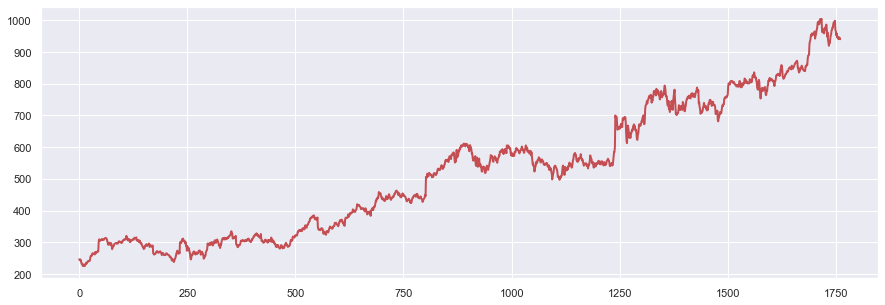

In [6]:
fig = plt.figure(figsize = (15,5))
plt.plot(close, color='r', lw=2.)
plt.plot(close, '^', markersize=10, color='m', label = 'buying signal', markevery = states_buy)
plt.plot(close, 'v', markersize=10, color='k', label = 'selling signal', markevery = states_sell)
plt.title('total gains %f, total investment %f%%'%(total_gains, invest))
plt.legend()
plt.show()